In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [2]:
# Read the data
raw_dataset = pd.read_csv("../DATA/league_games.csv")

# Alterando o conjunto de dados
Como observado no notebook `initial-analysis.ipynb` o modelo _baseline_ apresentou taxa de acerto acima de 98%. Esse resultado sugere que a seleção das features (comparar os dados entre as equipes) não foi boa. Nesse sentido, decidimos remodelar o problema.

O novo problema será _com base nos dados relacionados à equipe azul, vamos tentar prever o outcome da partida, ou seja, se a equipe azul ganhou ou não_. Com isso em mente, precisamos remover algumas features do conjunto anterior.

In [3]:
# Print all columns name
display(raw_dataset.columns)

Index(['blue.win', 'blue.firstBlood', 'blue.firstTower', 'blue.firstInhibitor',
       'blue.firstBaron', 'blue.firstDragon', 'blue.firstRiftHerald',
       'blue.towerKills', 'blue.inhibitorKills', 'blue.baronKills',
       'blue.dragonKills', 'blue.riftHeraldKills', 'red.win', 'red.firstBlood',
       'red.firstTower', 'red.firstInhibitor', 'red.firstBaron',
       'red.firstDragon', 'red.firstRiftHerald', 'red.towerKills',
       'red.inhibitorKills', 'red.baronKills', 'red.dragonKills',
       'red.riftHeraldKills', 'blue.kills', 'red.kills', 'blue.deaths',
       'red.deaths', 'blue.assists', 'red.assists', 'blue.visionScore',
       'red.visionScore', 'blue.csPerMin', 'red.csPerMin', 'blue.goldPerMin',
       'red.goldPerMin', 'blue.crowdControlTime', 'red.crowdControlTime'],
      dtype='object')

In [4]:
# Create a new dataset without red team information
to_drop = [
    'red.win', 'red.firstBlood', 'red.firstTower', 'red.firstInhibitor',
    'red.firstBaron', 'red.firstDragon', 'red.firstRiftHerald', 'red.towerKills',
    'red.inhibitorKills', 'red.baronKills', 'red.dragonKills', 'red.riftHeraldKills',
    'red.kills', 'red.deaths', 'red.assists', 'red.visionScore', 'red.csPerMin',
    'red.goldPerMin', 'red.crowdControlTime'
]

blue_dataset = raw_dataset.copy()
blue_dataset.drop(to_drop, axis=1, inplace=True)

display(blue_dataset.columns)

Index(['blue.win', 'blue.firstBlood', 'blue.firstTower', 'blue.firstInhibitor',
       'blue.firstBaron', 'blue.firstDragon', 'blue.firstRiftHerald',
       'blue.towerKills', 'blue.inhibitorKills', 'blue.baronKills',
       'blue.dragonKills', 'blue.riftHeraldKills', 'blue.kills', 'blue.deaths',
       'blue.assists', 'blue.visionScore', 'blue.csPerMin', 'blue.goldPerMin',
       'blue.crowdControlTime'],
      dtype='object')

In [5]:
# Print more informations
display(blue_dataset.dtypes, blue_dataset.shape)

blue.win                   int64
blue.firstBlood            int64
blue.firstTower            int64
blue.firstInhibitor        int64
blue.firstBaron            int64
blue.firstDragon           int64
blue.firstRiftHerald       int64
blue.towerKills            int64
blue.inhibitorKills        int64
blue.baronKills            int64
blue.dragonKills           int64
blue.riftHeraldKills       int64
blue.kills                 int64
blue.deaths                int64
blue.assists               int64
blue.visionScore           int64
blue.csPerMin            float64
blue.goldPerMin          float64
blue.crowdControlTime      int64
dtype: object

(16272, 19)

# Planejando a _baseline_
O modelo _baseline_ servirá como um "guia" para mensurar a qualidade dos modelos mais sofisticados. A _baseline_, nesse caso, poderá nos informar sobre possíveis complexidades desnecessárias.

Neste projeto, nossa _baseline_ será definida por uma Regressão Logística. Neste modelo, as probabilidades que descrevem os possíveis resultados de uma única tentativa são modeladas usando uma função logística. A implementação escolhida foi a `LogisticRegression` da biblioteca **scikit-learn**.

Inicialmente iremos separar o conjunto `blue_dataset` em dois subconjuntos: treinamento e teste. Esse tipo de procedimento é importante para evitar o problema de _overfitting_. Usando a biblioteca scikit-learn podemos separar aleatoriamente o conjunto principal a partir da função auxiliar `train_test_split`. A separação será feita usando a relação 80/20, ou seja, 80% dos dados serão de treinamento e os 20% restantes serão de teste.

Dentro do conjunto de treinamento, podemos utilizar o procedimento de validação. A seleção do conjunto de validação será feita utilizando o método de _cross-validation_ (CV) **stratified k-fold** com 10 _splits_ e 4 repetições (no scikit-learn, `RepeatedStratifiedKFold`). Os parâmetros testados para a Regressão Logística serão:
- Com e sem regularização (usando penalidade `l2`);
- Inverso do peso da regularização $C$: 0.1, 0.5, 1.0, 10, 100, 1000;

Esperamos com todos esses fatores que nossa _baseline_ seja bastante robusta.

In [6]:
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedStratifiedKFold
from sklearn.metrics import classification_report, plot_confusion_matrix
from sklearn.linear_model import LogisticRegression

In [7]:
def split_80_20(df):
    """
    Split Dataframe df into random train and test subsets. Using 80/20
    division.

    Parameters
    ----------
    df : DataFrame
        Dataset to be splitted.
    
    Returns
    -------
    X_train : DataFrame
        Training dataset.
    X_test : DataFrame
        Testing dataset.
    y_train : Series
        Training targets.
    y_test : Series
        Testing targets.
    """
    # Split dataset into features and target.
    target_name = "blue.win"
    target = df[target_name]
    features = df.drop(target_name, 1)

    # Split into train and test subsets.
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

    return X_train, X_test, y_train, y_test

In [8]:
X_train, X_test, y_train, y_test = split_80_20(blue_dataset)
print("==> Training subset:", end="")
display(X_train.shape, y_train.shape)
print("==> Testing subset:", end="")
display(X_test.shape, y_test.shape)

==> Training subset:

(13017, 18)

(13017,)

==> Testing subset:

(3255, 18)

(3255,)

In [9]:
def _define_baseline():
    """
    Baseline model declaration.

    Returns
    -------
    baseline : classifier object
        Baseline it self.
    """
    parameters = {'penalty': ['none', 'l2'], 'C': [0.1, 0.5, 1.0, 10, 100, 1000]}
    lr = LogisticRegression(random_state=42)
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=4, random_state=42)
    clf = GridSearchCV(lr, parameters, cv=cv)

    return clf

def _eval_model(
        model, X_train, X_test, y_train, y_test,
        params=False, digits_fmt=4):
    """
    Displays evaluation metrics including classification report and
    confusion matrix.
    
    If the argument 'params' is passed, will display a table of the 
    parameters hyperparameters used in the model.

    This function is associated with `fit_and_evaluate()`. More 
    information see its description.

    Parameters
    ----------
    digits_fmt : int
        Number of digits for formatting output floating point values.
    """
    # Get predictions.
    y_predict_train = model.predict(X_train)
    y_predict_test = model.predict(X_test)

    # Classification report
    print("=== CLASSIFICATION REPORT - TRAINING DATA ===")
    print(classification_report(y_train, y_predict_train, digits=digits_fmt))

    print("=== CLASSIFICATION REPORT - TESTING DATA ===")
    print(classification_report(y_test, y_predict_test, digits=digits_fmt))

    print("=== CONFUSION MATRIX ===")
    fig, ax = plt.subplots(figsize=(5,5))
    plot_confusion_matrix(
        model, X_test, y_test,
        normalize="true",
        cmap="Purples",
        ax=ax)
    ax.set_title("Confusion Matrix")
    plt.show()

    if params:
        print("=== MODEL PARAMETERS ===")
        params = pd.DataFrame(pd.Series(model.get_params()))
        params.columns["parameters"]
        display(params)

def fit_and_evaluate(model, X_train, X_test, y_train, y_test, params=False):
    """
    Fits model on training data and displays classification evaluation metrics.

    Parameters
    ----------
    model : classifier object
        Type of classificatier model to use.
    X_train : DataFrame
        Training data with features variables.
    X_test : DataFrame
        Testing data with features variables.
    y_train : Series
        Training data with target variable.
    y_test : Series
        Testing data with target variable.
    params : bool
        Prints table of hyperparameters used in model.
        
    Returns
    -------
    model : classifier object
        Model after fitting on training data.
    """
    model.fit(X_train, y_train)
    _eval_model(model, X_train, X_test, y_train, y_test, params=params)

    return model

=== CLASSIFICATION REPORT - TRAINING DATA ===
              precision    recall  f1-score   support

           0     0.9780    0.9742    0.9761      6520
           1     0.9742    0.9780    0.9761      6497

    accuracy                         0.9761     13017
   macro avg     0.9761    0.9761    0.9761     13017
weighted avg     0.9761    0.9761    0.9761     13017

=== CLASSIFICATION REPORT - TESTING DATA ===
              precision    recall  f1-score   support

           0     0.9816    0.9668    0.9741      1655
           1     0.9662    0.9812    0.9736      1600

    accuracy                         0.9739      3255
   macro avg     0.9739    0.9740    0.9739      3255
weighted avg     0.9740    0.9739    0.9739      3255

=== CONFUSION MATRIX ===


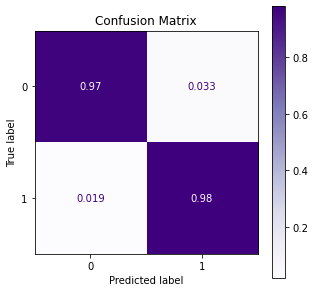

In [10]:
baseline = fit_and_evaluate(
    _define_baseline(), X_train, X_test, y_train, y_test)

In [11]:
baseline.get_params()

{'cv': RepeatedStratifiedKFold(n_repeats=4, n_splits=10, random_state=42),
 'error_score': nan,
 'estimator__C': 1.0,
 'estimator__class_weight': None,
 'estimator__dual': False,
 'estimator__fit_intercept': True,
 'estimator__intercept_scaling': 1,
 'estimator__l1_ratio': None,
 'estimator__max_iter': 100,
 'estimator__multi_class': 'auto',
 'estimator__n_jobs': None,
 'estimator__penalty': 'l2',
 'estimator__random_state': 42,
 'estimator__solver': 'lbfgs',
 'estimator__tol': 0.0001,
 'estimator__verbose': 0,
 'estimator__warm_start': False,
 'estimator': LogisticRegression(random_state=42),
 'n_jobs': None,
 'param_grid': {'penalty': ['none', 'l2'],
  'C': [0.1, 0.5, 1.0, 10, 100, 1000]},
 'pre_dispatch': '2*n_jobs',
 'refit': True,
 'return_train_score': False,
 'scoring': None,
 'verbose': 0}